# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook
import os

In [177]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [369]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm_notebook(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [370]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm_notebook(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8394440412521362), ('excellent', 0.8156204223632812), ('awesome', 0.811806321144104), ('good', 0.8079538345336914), ('terrific', 0.7930084466934204), ('wonderful', 0.7642905712127686), ('perfect', 0.7561423778533936), ('nice', 0.7213498950004578), ('amazing', 0.694490909576416), ('decent', 0.6802260875701904)]
[('greatest', 0.7778383493423462), ('best', 0.7105495929718018), ('tastiest', 0.69941246509552), ('nastiest', 0.6649028062820435), ('disgusting', 0.6559326648712158), ('closest', 0.6327559947967529), ('awful', 0.6302951574325562), ('freshest', 0.6242843270301819), ('horrible', 0.6163777112960815), ('terrible', 0.6085253357887268)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [431]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm_notebook(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm_notebook(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [151]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import math
bow_vect=CountVectorizer()
x=preprocessed_reviews
y=np.array(final['Score'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.3)
fbowx_tr=bow_vect.fit_transform(x_train)
fbowx_cv=bow_vect.transform(x_cv)
fbowx_te=bow_vect.transform(x_test)

In [152]:
std=StandardScaler(with_mean=False) #Standardizing Data
fbowx_tr=std.fit_transform(fbowx_tr)
fbowx_cv=std.transform(fbowx_cv)
fbowx_te=std.transform(fbowx_te)
logr=LogisticRegression(penalty='l1',C=1.0,class_weight=None,solver='liblinear')
logr.fit(fbowx_tr,y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [153]:
print(fbowx_tr.shape, y_train.shape)
print(fbowx_cv.shape, y_cv.shape)
print(fbowx_te.shape, y_test.shape)

(43008, 39009) (43008,)
(18433, 39009) (18433,)
(26332, 39009) (26332,)


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [22:00<00:00, 165.09s/it]


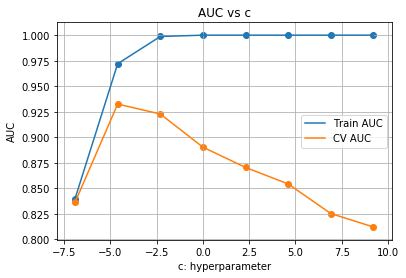

Best c value for max auc = 99.0


In [154]:
from sklearn.metrics import roc_auc_score
auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm(c): #simple cv using for loop
    logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(fbowx_tr,y_train)
    pred_b = logr.predict_proba(fbowx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_b))
    pred_b1=logr.predict_proba(fbowx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_b1))
best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
c=[math.log(j) for j in c]    
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

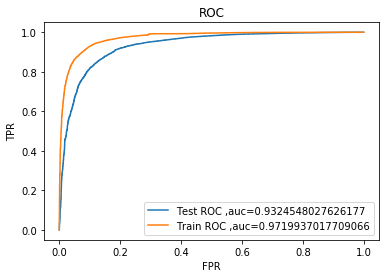

In [155]:
#Plotting ROC_AUC curve
logr=LogisticRegression(penalty='l1',C=best_c,solver='liblinear').fit(fbowx_tr,y_train)
pred=logr.predict_proba(fbowx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_tf=logr.predict_proba(fbowx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tf)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tf)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [156]:
#Function to find threshold  
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.8364623776680721 for threshold 0.774
Train confusion matrix


Text(33,0.5,'Actual Label')

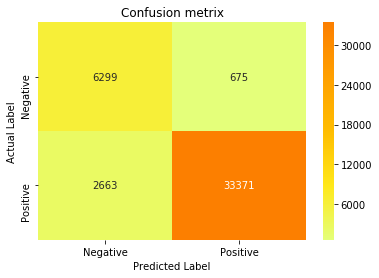

In [157]:
#Comfuion matrix for Train data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Train confusion matrix")
df=pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(pred_tf, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.8364623776680721 for threshold 0.774
Test confusion matrix


Text(33,0.5,'Actual Label')

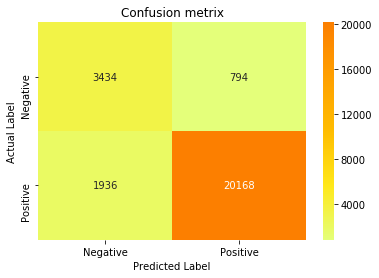

In [158]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [255]:
# Please write all the code with proper documentation
logr=LogisticRegression(penalty='l1',C=best_c,solver='liblinear',random_state=0).fit(fbowx_tr,y_train)
w=logr.coef_
print(len(w[0]))
print("The no. of non zero elements=",np.count_nonzero(w))

39009
The no. of non zero elements= 2856


In [253]:
#Cross Check if weights are correct
count_0=0
count_1=0
for i in range(len(w[0])):
    if w[0][i]!=0:
        count_1+=1
    else:
        count_0+=1
        #print(i,w[0][i])
print('zero_count=',count_0)
print('Non_zero_count',count_1)
print('Sum=',count_0+count_1)

zero_count= 36153
Non_zero_count 2856
Sum= 39009


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [289]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import math
bow_vect=CountVectorizer()

x=preprocessed_reviews
y=np.array(final['Score'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train)
fbowx_tr=bow_vect.fit_transform(x_train)
fbowx_cv=bow_vect.transform(x_cv)
fbowx_te=bow_vect.transform(x_test)

In [290]:
std=StandardScaler(with_mean=False)#Standardizing Data
fbowx_tr=std.fit_transform(fbowx_tr)
fbowx_cv=std.transform(fbowx_cv)
fbowx_te=std.transform(fbowx_te)

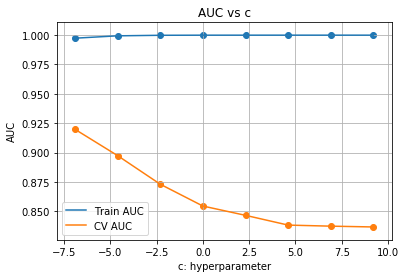

Best c value for max auc = 999.0


In [291]:
from sklearn.metrics import roc_auc_score
auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c): #simple cv using for loop
    logr=LogisticRegression(penalty='l2',C=i).fit(fbowx_tr,y_train)
    pred_b = logr.predict_proba(fbowx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_b))
    pred_b1=logr.predict_proba(fbowx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_b1))
best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
c=[math.log(j) for j in c]    
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

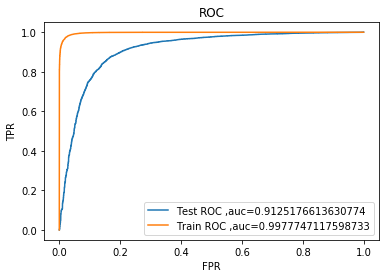

In [278]:
#Plotting ROC_AUC curve
logr=LogisticRegression(penalty='l2',C=best_c).fit(fbowx_tr,y_train)
pred=logr.predict_proba(fbowx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_tf=logr.predict_proba(fbowx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tf)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tf)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.8425649906390592 for threshold 0.793
Train confusion matrix


Text(33.0, 0.5, 'Actual Label')

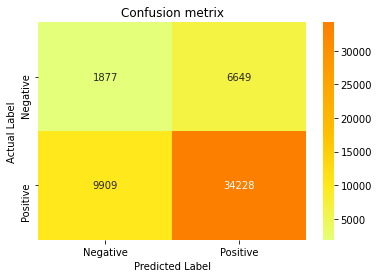

In [ ]:
#Comfuion matrix for Train data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Train confusion matrix")
df=pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(pred_tf, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.8425649906390592 for threshold 0.793
Test confusion matrix


Text(33.0, 0.5, 'Actual Label')

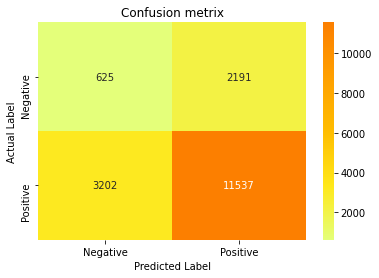

In [ ]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [185]:
# Please write all the code with proper documentation
# Adding small e values

x_e=fbowx_tr
x_e.data=x_e.data+np.random.normal(loc=0,scale=0.0001,size=x_e.data.shape)
x_e.shape
#Code for Performing pertubation test is copied and modified from sample solution sent from AAIC team

(43008, 39009)

In [256]:
w=logr.coef_
logr_e=LogisticRegression(penalty='l2',C=best_c).fit(x_e,y_train) 
w_d=logr_e.coef_
w+=10**-6 #Adding very small vakue to avoid divide by zero error
w_d+=10**-6
changed_weights = np.absolute(((w - w_d) - w_d)) * 100
percentiles_0_100 = []
for i in range(11):
    print(str(i*10)+' percentile = '+str(np.percentile(changed_weights,i*10)))
#Code for Performing pertubation test is copied and modified from sample solution sent from AAIC team

0 percentile = 3.572213214728522e-07
10 percentile = 0.0022551099781929753
20 percentile = 0.0621454657191864
30 percentile = 0.273829241442145
40 percentile = 0.5866787717339094
50 percentile = 0.9939085323740428
60 percentile = 1.5114156910875767
70 percentile = 2.3018395501259397
80 percentile = 3.5375623892302928
90 percentile = 5.876897360026403
100 percentile = 97.82396235966988


In [237]:
#From 90 to 100
for i in range(90,101):
    print(str(i)+'th percentile = '+str(np.percentile(changed_weights,i)))

90th percentile = 5.876997360026402
91th percentile = 6.275342444220985
92th percentile = 6.737075052379013
93th percentile = 7.221173217216251
94th percentile = 7.77847163322523
95th percentile = 8.463096969770268
96th percentile = 9.351981040184118
97th percentile = 10.458439082692824
98th percentile = 11.875958583516105
99th percentile = 14.786444340260394
100th percentile = 97.82401115727369


In [246]:
#From 99.1 to 100
percentiles__100 = []
for i in range(1,11):
    print(str(99+(10**-1)*i)+'th percentile = '+str(np.percentile(changed_weights,99+(10**-1)*i)))
    

99.1th percentile = 15.202867134256167
99.2th percentile = 15.60660935612353
99.3th percentile = 15.978862397200666
99.4th percentile = 16.659456725386946
99.5th percentile = 17.398428889476172
99.6th percentile = 18.446141229626654
99.7th percentile = 19.569975223926857
99.8th percentile = 20.953578685097813
99.9th percentile = 24.36967678284655
100.0th percentile = 97.82401115727369


In [245]:
#Print the feature names
features = bow_vect.get_feature_names()
index_percentile_99 = int((x_e.shape[1]*99.9) / 100)
features_from_99th_to_100_percentile = features[index_percentile_99:]

# Their feature names.
print(list(features_from_99th_to_100_percentile))
print(len(features_from_99th_to_100_percentile))

['ziyad', 'zoe', 'zoey', 'zoji', 'zojirushi', 'zoka', 'zombie', 'zombies', 'zomg', 'zon', 'zone', 'zones', 'zoo', 'zoom', 'zoomed', 'zooming', 'zoonotic', 'zoos', 'zours', 'zout', 'zp', 'zreport', 'zsweet', 'zucchini', 'zuccini', 'zucini', 'zucs', 'zuk', 'zuke', 'zukes', 'zulu', 'zuma', 'zumba', 'zupas', 'zwieback', 'zx', 'zylitol', 'zz', 'zzzzz', 'zzzzzzzzzzz']
40


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation
all_features = bow_vect.get_feature_names()
weight=logr.coef_
positive=np.argsort(weight)[:,::-1]
negative=np.argsort(weight)

print('Top 10 positive features :')
for i in list(positive[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
best
delicious
good
perfect
love
loves
excellent
wonderful
nice


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation
print('Top 10 positive features :')
for i in list(negative[0][0:10]):
    print(all_features[i])

Top 10 positive features :
not
disappointed
worst
awful
money
terrible
horrible
disappointing
thought
disappointment


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [381]:
# Please write all the code with proper documentation
tf_vect=TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_vect.fit(preprocessed_reviews)
ftfx_tr=tf_vect.fit_transform(x_train)
ftfx_cv=tf_vect.transform(x_cv)
ftfx_te=tf_vect.transform(x_test)
ftfx_tr=std.fit_transform(ftfx_tr)#Standardizing Data
ftfx_cv=std.transform(ftfx_cv)
ftfx_te=std.transform(ftfx_te)

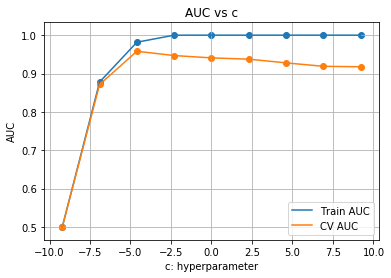

Best c value for max auc = 99.0


In [382]:
auc_cv=[]
auc_train=[]
c=[0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):      #simple cv using for loop
    logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(ftfx_tr,y_train)
    pred_tf = logr.predict_proba(ftfx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_tf))
    pred_tf1=logr.predict_proba(ftfx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_tf1))
best_c= c[auc_cv.index(max(auc_cv))]
c=[math.log(j) for j in c]
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)


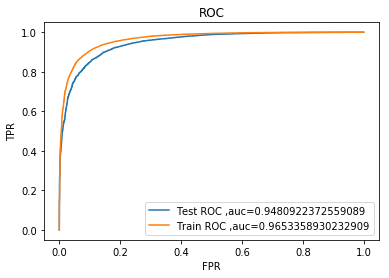

In [389]:
#Plotting ROC curve
logr=LogisticRegression(penalty='l1',C=best_c,solver='liblinear').fit(ftfx_tr,y_train)
pred_tf=logr.predict_proba(ftfx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred_tf)
pred_tf1=logr.predict_proba(ftfx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tf1)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred_tf)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tf1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.8721420116971756 for threshold 0.802
Train confusion matrix


Text(33,0.5,'Actual Label')

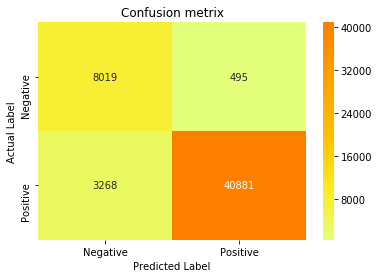

In [384]:
#Comfuion matrix for Train data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Train confusion matrix")
df=pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(pred_tf1, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.8721420116971756 for threshold 0.802
Test confusion matrix


Text(33,0.5,'Actual Label')

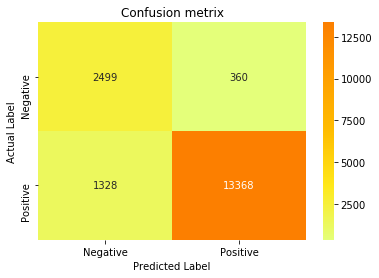

In [385]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred_tf, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [402]:
# Please write all the code with proper documentation
tf_vect=TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_vect.fit(preprocessed_reviews)

ftfx_tr=tf_vect.fit_transform(x_train)
ftfx_cv=tf_vect.transform(x_cv)
ftfx_te=tf_vect.transform(x_test)

std=StandardScaler(with_mean=False)
ftfx_tr=std.fit_transform(ftfx_tr)
ftfx_cv=std.transform(ftfx_cv)
ftfx_te=std.transform(ftfx_te)

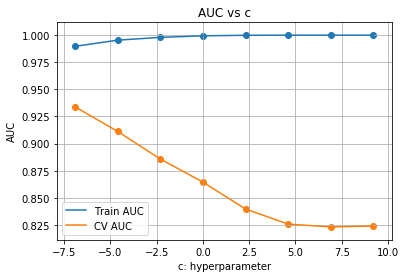

Best c value for max auc = 999.0


In [403]:
tf_vect=TfidfVectorizer(min_df=10)
tf_vect.fit(preprocessed_fe_reviews)

ftfx_tr=tf_vect.fit_transform(x_train)
ftfx_cv=tf_vect.transform(x_cv)
ftfx_te=tf_vect.transform(x_test)
logr=LogisticRegression(penalty='l2',C=i).fit(ftfx_tr,y_train)
std=StandardScaler(with_mean=False)
ftfx_tr=std.fit_transform(ftfx_tr)
ftfx_cv=std.transform(ftfx_cv)
ftfx_te=std.transform(ftfx_te)
auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):      #simple cv using for loop
    logr=LogisticRegression(penalty='l2',C=i).fit(ftfx_tr,y_train)
    pred_tf = logr.predict_proba(ftfx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_tf))
    pred_tf1=logr.predict_proba(ftfx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_tf1))
best_c= c[auc_cv.index(max(auc_cv))]
c=[math.log(j) for j in c]
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

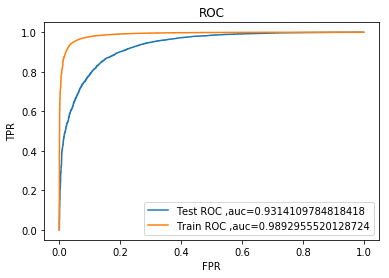

In [404]:
#Plotting ROC curve
logr=LogisticRegression(penalty='l2',C=best_c).fit(ftfx_tr,y_train)
pred_tf=logr.predict_proba(ftfx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred_tf)
pred_tf1=logr.predict_proba(ftfx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tf1)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred_tf)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tf1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.9071401028399713 for threshold 0.77
Train confusion matrix


Text(33,0.5,'Actual Label')

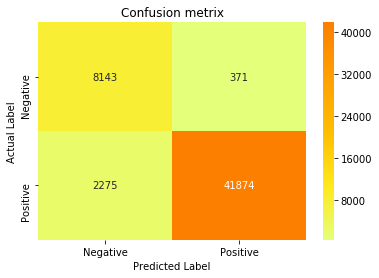

In [405]:
#Comfuion matrix for Train data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Train confusion matrix")
df=pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(pred_tf1, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.9071401028399713 for threshold 0.77
Test confusion matrix


Text(33,0.5,'Actual Label')

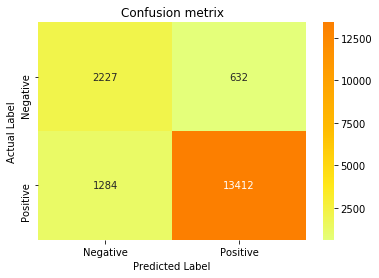

In [406]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred_tf, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [413]:
# Please write all the code with proper documentation
all_features_tf=tf_vect.get_feature_names()
weight_tf=logr.coef_
positive_tf=np.argsort(weight_tf)[:,::-1]
negative_tf=np.argsort(weight_tf)
print("Top 10 important features of positive class")
for i in list(positive_tf[0][0:10]):
  print(all_features_tf[i])

Top 10 important features of positive class
great
best
delicious
love
good
perfect
nice
loves
excellent
wonderful


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [414]:
# Please write all the code with proper documentation
print("Top 10 important features of negative class:")
for i in list(negative_tf[0][0:10]):
    print(all_features_tf[i])


Top 10 important features of negative class:
not
disappointed
worst
terrible
awful
disappointing
horrible
disappointment
waste
money


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation
x=np.array(preprocessed_reviews)
y=np.array(final['Score'])

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.3)

#Avg word2vec for train data
sent_train_list=[]
for sentence in x_train:
    sent_train_list.append(sentence.split())
w2v_model=Word2Vec(sent_train_list,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm_notebook(sent_train_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))

#Avg word2vec for cv data
sent_cv_list=[]
for sentence in x_cv:
    sent_cv_list.append(sentence.split())

sent_cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm_notebook(sent_cv_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_cv_vectors.append(sent_vec)
print(len(sent_cv_vectors))
print(len(sent_cv_vectors[0]))


#Avg word2vec for test data
sent_test_list=[]
for sentence in x_test:
    sent_test_list.append(sentence.split())

sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm_notebook(sent_test_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))


#This code is copied and modified from :https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW#scrollTo=3-XGItt4PSx0



43008
50



18433
50



26332
50


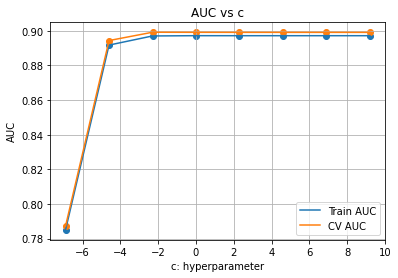

Best c value for max auc = 1


In [ ]:
aw2vx_tr=sent_train_vectors
aw2vx_cv=sent_cv_vectors
aw2vx_te=sent_test_vectors

auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):
    logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(aw2vx_tr,y_train)
    pred = logr.predict_proba(aw2vx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred_aw=logr.predict_proba(aw2vx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_aw))
#best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
best_c=1
c=[math.log(j) for j in c]       
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

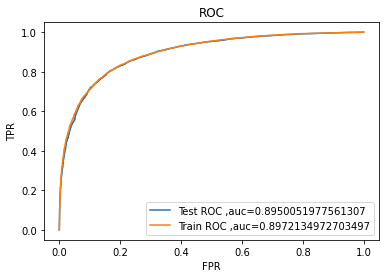

In [ ]:
#Plotting ROC Curve
from sklearn.metrics import roc_auc_score
logr=LogisticRegression(penalty='l1',C=best_c,solver='liblinear').fit(aw2vx_tr,y_train)
pred=logr.predict_proba(aw2vx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_aw=logr.predict_proba(aw2vx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_aw)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_aw)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


the maximum value of tpr*(1-fpr) 0.6695422821409518 for threshold 0.829
Train confusion matrix


Text(33.0, 0.5, 'Actual Label')

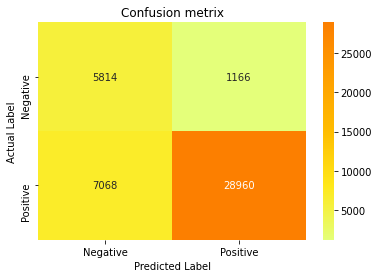

In [ ]:
#Comfuion matrix for Train data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Train confusion matrix")
df=pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(pred_aw, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.6695422821409518 for threshold 0.829
Test confusion matrix


Text(33.0, 0.5, 'Actual Label')

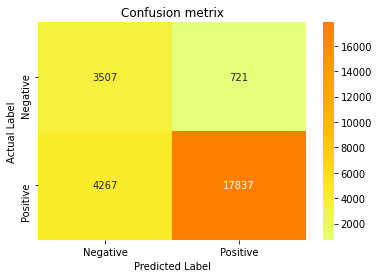

In [ ]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

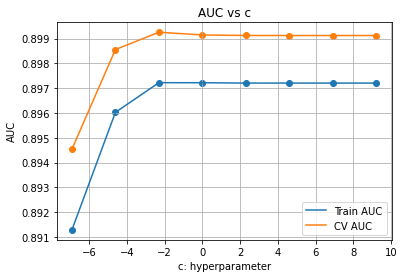

Best c value for max auc = 9.0


In [ ]:
# Please write all the code with proper documentation

auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):
    logr=LogisticRegression(penalty='l2',C=i).fit(aw2vx_tr,y_train)
    pred = logr.predict_proba(aw2vx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred_aw=logr.predict_proba(aw2vx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_aw))
best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
c=[math.log(j) for j in c]       
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

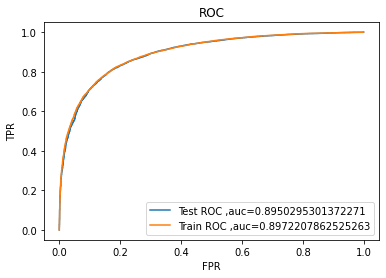

In [ ]:
#Plotting ROC Curve
from sklearn.metrics import roc_auc_score
logr=LogisticRegression(penalty='l2',C=best_c).fit(aw2vx_tr,y_train)
pred=logr.predict_proba(aw2vx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_aw=logr.predict_proba(aw2vx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_aw)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_aw)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [ ]:
#Comfuion matrix for Train data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Train confusion matrix")
df=pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(pred_aw, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.8425649906390592 for threshold 0.793
Test confusion matrix


Text(33.0, 0.5, 'Actual Label')

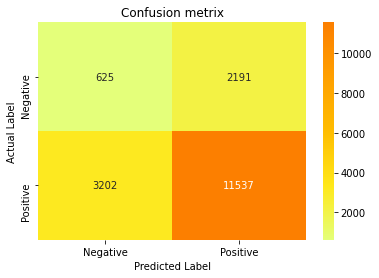

In [ ]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [57]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticReession
from sklearn.preprocessing import StandardScaler
import math
x=preprocessed_reviews
y=np.array(final['Score'])

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.3)
sent_train_list=[]
for sentence in x_train:
    sent_train_list.append(sentence.split())
w2v_model=Word2Vec(sent_train_list,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_matrix=tf_idf_vect.fit_transform(x_train)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#Train data
tfidf_sent_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm_notebook(sent_train_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_train_vectors.append(sent_vec)
    row += 1
    
#for cv
sent_cv_list=[]
for sentence in x_cv:
    sent_cv_list.append(sentence.split())
tfidf_sent_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm_notebook(sent_cv_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_cv_vectors.append(sent_vec)
    row += 1
    
#Test data
sent_test_list=[]
for sentence in x_test:
    sent_test_list.append(sentence.split())
tfidf_sent_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm_notebook(sent_test_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_test_vectors.append(sent_vec)
    row += 1

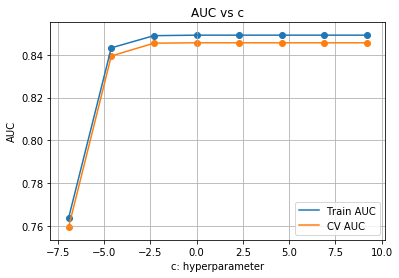

Best c value for max auc = 1


In [58]:
tfw2vx_tr=tfidf_sent_train_vectors
tfw2vx_cv=tfidf_sent_cv_vectors
tfw2vx_te=tfidf_sent_test_vectors
auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):
    logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(tfw2vx_tr,y_train)
    pred = logr.predict_proba(tfw2vx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred_tfw=logr.predict_proba(tfw2vx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_tfw))
                    
best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
c=[math.log(j) for j in c]       
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

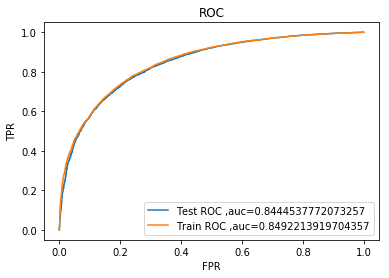

In [61]:
#Plotting ROC Curve
from sklearn.metrics import confusion_matrix
logr=LogisticRegression(penalty='l1',C=best_c,solver='liblinear').fit(tfw2vx_tr,y_train)
pred=logr.predict_proba(tfw2vx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_tfw=logr.predict_proba(tfw2vx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tfw)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tfw)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.5916110092394808 for threshold 0.821
Train confusion matrix


Text(33,0.5,'Actual Label')

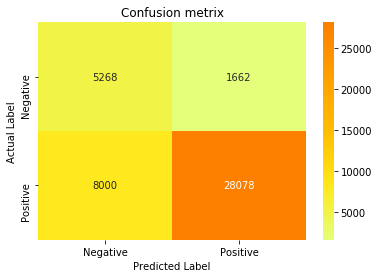

In [63]:
#Comfuion matrix for Train data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Train confusion matrix")
df=pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(pred_tfw, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.5916110092394808 for threshold 0.821
Test confusion matrix


Text(33,0.5,'Actual Label')

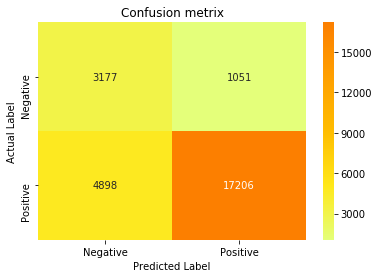

In [64]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

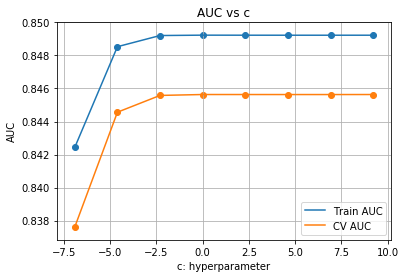

Best c value for max auc = 1


In [65]:
# Please write all the code with proper documentation
tfw2vx_tr=tfidf_sent_train_vectors
tfw2vx_cv=tfidf_sent_cv_vectors
tfw2vx_te=tfidf_sent_test_vectors
auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):
    logr=LogisticRegression(penalty='l2',C=i).fit(tfw2vx_tr,y_train)
    pred = logr.predict_proba(tfw2vx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred_tfw=logr.predict_proba(tfw2vx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_tfw))
                    
best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
c=[math.log(j) for j in c]       
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

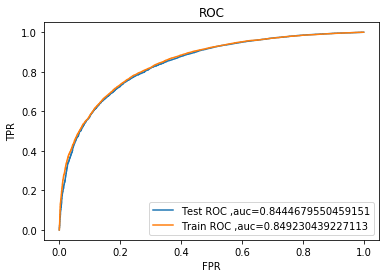

In [66]:
#Plotting ROC Curve
from sklearn.metrics import confusion_matrix
logr=LogisticRegression(penalty='l2',C=best_c).fit(tfw2vx_tr,y_train)
pred=logr.predict_proba(tfw2vx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_tfw=logr.predict_proba(tfw2vx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tfw)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tfw)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.5915751561851679 for threshold 0.82
Train confusion matrix


Text(33,0.5,'Actual Label')

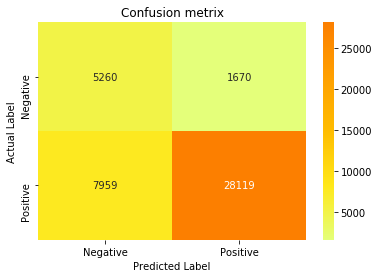

In [67]:
#Comfuion matrix for Train data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Train confusion matrix")
df=pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(pred_tfw, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

the maximum value of tpr*(1-fpr) 0.5915751561851679 for threshold 0.82
Test confusion matrix


Text(33,0.5,'Actual Label')

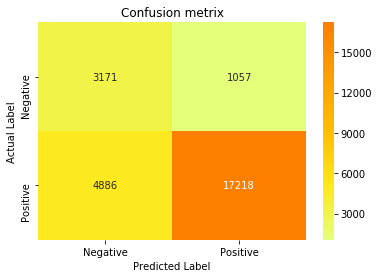

In [68]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

### [5.5] Feature Engineering

#### [5.5.1] Logistic regression with L1 and featuring engineering on BOW

In [367]:
for i in range(len(preprocessed_reviews)):  #considering  some features from reviw summary and length of review text
    preprocessed_reviews[i]=preprocessed_reviews[i]+ ' '+preprocessed_summary[i]+' '+str(len(final.Text.iloc[i]))
preprocessed_fe_reviews=preprocessed_reviews   

In [415]:
preprocessed_fe_reviews[1500]

'way hot blood took bite jig lol way hot blood took bite jig lol 59'

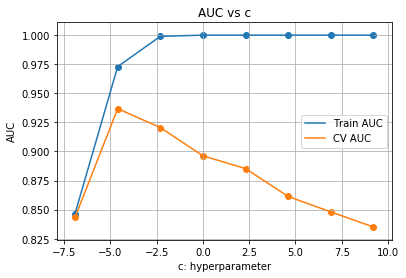

Best c value for max auc = 99.0


In [416]:
bow_vect=CountVectorizer()
x=preprocessed_fe_reviews
y=np.array(final['Score'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train)
fbowx_tr=bow_vect.fit_transform(x_train)
fbowx_cv=bow_vect.transform(x_cv)
fbowx_te=bow_vect.transform(x_test)

std=StandardScaler(with_mean=False)#Standardizing Data
fbowx_tr=std.fit_transform(fbowx_tr)
fbowx_cv=std.transform(fbowx_cv)
fbowx_te=std.transform(fbowx_te)

auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c): #simple cv using for loop
    logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(fbowx_tr,y_train)
    pred_b = logr.predict_proba(fbowx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_b))
    pred_b1=logr.predict_proba(fbowx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_b1))
best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
c=[math.log(j) for j in c]    
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

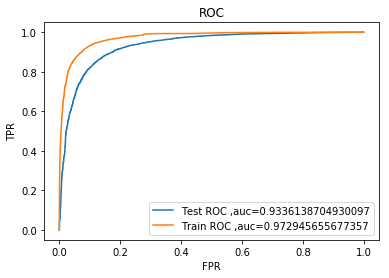

In [417]:
#Plotting ROC_AUC curve
logr=LogisticRegression(penalty='l1',C=best_c,solver='liblinear').fit(fbowx_tr,y_train)
pred=logr.predict_proba(fbowx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_tf=logr.predict_proba(fbowx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tf)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tf)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.8400573344329587 for threshold 0.787
Test confusion matrix


Text(33,0.5,'Actual Label')

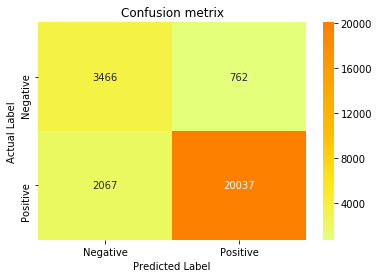

In [418]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

#### [5.5.2] Logistic regression with L1 and featuring engineering on TF-IDF

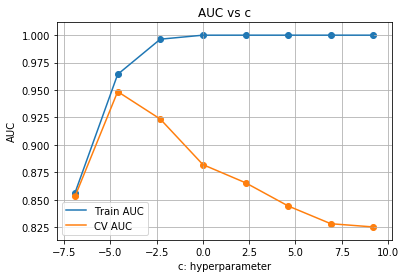

Best c value for max auc = 99.0


In [419]:
tf_vect=TfidfVectorizer(min_df=10)
tf_vect.fit(preprocessed_fe_reviews)

ftfx_tr=tf_vect.fit_transform(x_train)
ftfx_cv=tf_vect.transform(x_cv)
ftfx_te=tf_vect.transform(x_test)
logr=LogisticRegression(penalty='l2',C=i).fit(ftfx_tr,y_train)
std=StandardScaler(with_mean=False)
ftfx_tr=std.fit_transform(ftfx_tr)
ftfx_cv=std.transform(ftfx_cv)
ftfx_te=std.transform(ftfx_te)
logr=LogisticRegression(penalty='l1',C=1.0,solver='liblinear').fit(ftfx_tr,y_train)

auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):      #simple cv using for loop
    logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(ftfx_tr,y_train)
    pred_tf = logr.predict_proba(ftfx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_tf))
    pred_tf1=logr.predict_proba(ftfx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_tf1))
best_c= c[auc_cv.index(max(auc_cv))]
c=[math.log(j) for j in c]
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

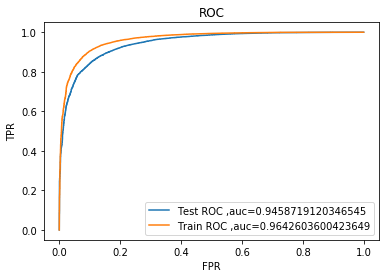

In [420]:
#Plotting ROC curve
logr=LogisticRegression(penalty='l1',C=best_c,solver='liblinear').fit(ftfx_tr,y_train)
pred_tf=logr.predict_proba(ftfx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred_tf)
pred_tf1=logr.predict_proba(ftfx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tf1)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred_tf)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tf1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.8149388370745456 for threshold 0.795
Test confusion matrix


Text(33,0.5,'Actual Label')

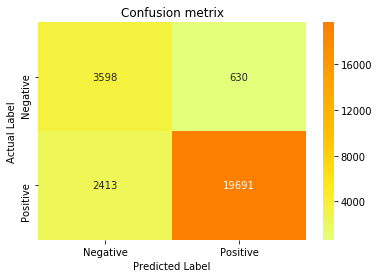

In [421]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred_tf, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

#### [5.5.3]Logistic regression with L1 anf featuring engineering on Avg Word 2 Vec

In [422]:
x=preprocessed_fe_reviews
y=np.array(final['Score'])

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.3)

#Avg word2vec for train data
sent_train_list=[]
for sentence in x_train:
    sent_train_list.append(sentence.split())
w2v_model=Word2Vec(sent_train_list,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm_notebook(sent_train_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))

#Avg word2vec for cv data
sent_cv_list=[]
for sentence in x_cv:
    sent_cv_list.append(sentence.split())

sent_cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm_notebook(sent_cv_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_cv_vectors.append(sent_vec)
print(len(sent_cv_vectors))
print(len(sent_cv_vectors[0]))


#Avg word2vec for test data
sent_test_list=[]
for sentence in x_test:
    sent_test_list.append(sentence.split())

sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm_notebook(sent_test_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))


#This code is copied and modified from :https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW#scrollTo=3-XGItt4PSx0


43008
50



18433
50



26332
50


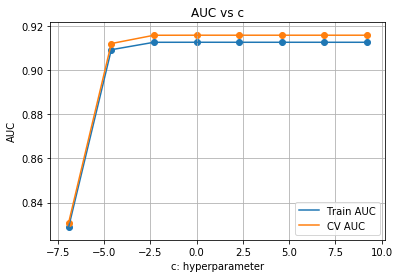

Best c value for max auc = 1


In [423]:
aw2vx_tr=sent_train_vectors
aw2vx_cv=sent_cv_vectors
aw2vx_te=sent_test_vectors
logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(aw2vx_tr,y_train)
auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):
    logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(aw2vx_tr,y_train)
    pred = logr.predict_proba(aw2vx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred_aw=logr.predict_proba(aw2vx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_aw))
best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
c=[math.log(j) for j in c]       
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

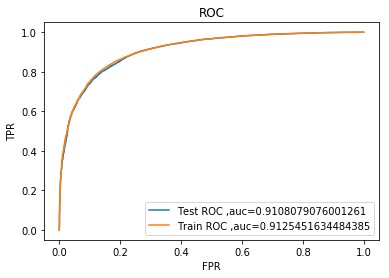

In [424]:
#Plotting ROC Curve
from sklearn.metrics import roc_auc_score
logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(aw2vx_tr,y_train)
pred=logr.predict_proba(aw2vx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_aw=logr.predict_proba(aw2vx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_aw)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_aw)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


the maximum value of tpr*(1-fpr) 0.6986168836005261 for threshold 0.826
Test confusion matrix


Text(33,0.5,'Actual Label')

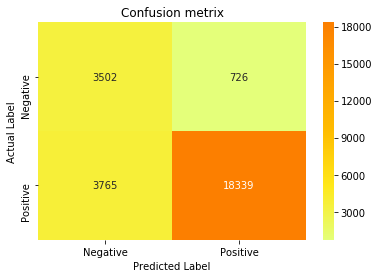

In [425]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

#### [5.5.4]Logistic regression with L1 anf featuring engineering on TF-IDF Word 2 Vec

In [426]:
x=preprocessed_fe_reviews
y=np.array(final['Score'])

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.3)
sent_train_list=[]
for sentence in x_train:
    sent_train_list.append(sentence.split())
w2v_model=Word2Vec(sent_train_list,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_matrix=tf_idf_vect.fit_transform(x_train)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#Train data
tfidf_sent_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm_notebook(sent_train_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_train_vectors.append(sent_vec)
    row += 1
    
#for cv
sent_cv_list=[]
for sentence in x_cv:
    sent_cv_list.append(sentence.split())
tfidf_sent_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm_notebook(sent_cv_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_cv_vectors.append(sent_vec)
    row += 1
    
#Test data
sent_test_list=[]
for sentence in x_test:
    sent_test_list.append(sentence.split())
tfidf_sent_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm_notebook(sent_test_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_test_vectors.append(sent_vec)
    row += 1

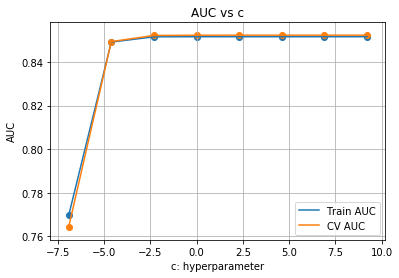

Best c value for max auc = 0


In [427]:
tfw2vx_tr=tfidf_sent_train_vectors
tfw2vx_cv=tfidf_sent_cv_vectors
tfw2vx_te=tfidf_sent_test_vectors
auc_cv=[]
auc_train=[]
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm_notebook(c):
    logr=LogisticRegression(penalty='l1',C=i,solver='liblinear').fit(tfw2vx_tr,y_train)
    pred = logr.predict_proba(tfw2vx_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred_tfw=logr.predict_proba(tfw2vx_tr)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_tfw))
                    
best_c= c[auc_cv.index(max(auc_cv))] #max value in auc_cv list is used to find best alpha
c=[math.log(j) for j in c]       
plt.plot(c, auc_train, label='Train AUC')
plt.plot(c, auc_cv, label='CV AUC')

plt.scatter(c, auc_train)
plt.scatter(c, auc_cv)
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs c")
plt.grid()
plt.show()
print("Best c value for max auc =",1//best_c)

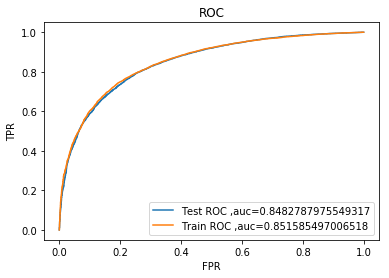

In [428]:
#Plotting ROC Curve
from sklearn.metrics import confusion_matrix
logr=LogisticRegression(penalty='l1',C=best_c,solver='liblinear').fit(tfw2vx_tr,y_train)
pred=logr.predict_proba(tfw2vx_te)[:,1]
fpr_te, trp_te, thresholds_te = metrics.roc_curve(y_test, pred)
pred_tfw=logr.predict_proba(tfw2vx_tr)[:,1]
fpr_tr,tpr_tr,thresholds_tr=metrics.roc_curve(y_train,pred_tfw)

plt.plot(fpr_te, trp_te, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr_tr, tpr_tr, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_tfw)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.6000074323944096 for threshold 0.845
Test confusion matrix


Text(33,0.5,'Actual Label')

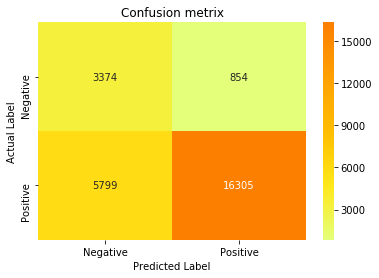

In [429]:
#Comfuion matrix for Test data
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, fpr_tr, tpr_tr)
print("Test confusion matrix")
df_b=pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(pred, best_t)),index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(df_b,annot = True,fmt='d',cmap="Wistia")
plt.title('Confusion metrix')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
#This code is copied and modified from: https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW

# [6] Conclusions

In [432]:
# Please compare all your models using Prettytable libraryFeature Engineering
import prettytable
x=PrettyTable()
x.field_names=(['Vectorizer','Regularization','Hyperparameter','AUC','Feature Engineering'])
x.add_row(['BOW','L1',99.0,0.932,'NO'])
x.add_row(['TF-IDF','L1',99.0,0.948,'NO'])
x.add_row(['AW2V','L1',1.0,0.895,'NO'])
x.add_row(['TF-IDF_w2v ','L1',1.0,0.844,'NO'])
x.add_row(['BOW','L2',999.0,0.912,'NO'])
x.add_row(['TF-IDF','L2',999.0,0.931,'NO'])
x.add_row(['AW2V','L2',9.0,0.895,'NO'])
x.add_row(['TF-IDF_w2v','L2',1.0,0.844,'NO'])
x.add_row(['BOW','L1',0.99,0.933,'YES'])
x.add_row(['TF-IDF','L1',99.0,0.945,'YES'])
x.add_row(['AW2V','L1',1.0,0.897,'YES'])
x.add_row(['TF-IDF_w2v','L1',0,0.848,'YES'])
print(x)

+-------------+----------------+----------------+-------+---------------------+
|  Vectorizer | Regularization | Hyperparameter |  AUC  | Feature Engineering |
+-------------+----------------+----------------+-------+---------------------+
|     BOW     |       L1       |      99.0      | 0.932 |          NO         |
|    TF-IDF   |       L1       |      99.0      | 0.948 |          NO         |
|     AW2V    |       L1       |      1.0       | 0.895 |          NO         |
| TF-IDF_w2v  |       L1       |      1.0       | 0.844 |          NO         |
|     BOW     |       L2       |     999.0      | 0.912 |          NO         |
|    TF-IDF   |       L2       |     999.0      | 0.931 |          NO         |
|     AW2V    |       L2       |      9.0       | 0.895 |          NO         |
|  TF-IDF_w2v |       L2       |      1.0       | 0.844 |          NO         |
|     BOW     |       L1       |      0.99      | 0.933 |         YES         |
|    TF-IDF   |       L1       |      99